In [34]:
import numpy as np
import pandas as pd

In [35]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [54]:
import itertools
import cv2
import matplotlib.pyplot as plt
import mediapipe

In [37]:
def load_pose_landmarks(csv_path):
  # Load the CSV file
  dataframe = pd.read_csv('data_set_v2.csv')
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  # df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [39]:
X, y, class_names, _ = load_pose_landmarks('data_set_v2.csv')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)

In [45]:
X_test, y_test, _, df_test = load_pose_landmarks('data_set_v2.csv')

In [48]:
inputs = tf.keras.Input(shape=(132))

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 132)]             0         
                                                                 
 dense (Dense)               (None, 128)               17024     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 25,475
Trainable params: 25,475
Non-trainable p

In [49]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [50]:
# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

In [51]:
# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
38/58 [==================>...........] - ETA: 0s - loss: 1.0453 - accuracy: 0.4852 
Epoch 1: val_accuracy improved from -inf to 0.82927, saving model to weights.best.hdf5
58/58 [==============================] - 1s 5ms/step - loss: 0.9552 - accuracy: 0.5460 - val_loss: 0.5470 - val_accuracy: 0.8293
Epoch 2/200
52/58 [=========================>....] - ETA: 0s - loss: 0.5730 - accuracy: 0.7945
Epoch 2: val_accuracy improved from 0.82927 to 0.96951, saving model to weights.best.hdf5
58/58 [==============================] - 0s 3ms/step - loss: 0.5660 - accuracy: 0.7974 - val_loss: 0.2760 - val_accuracy: 0.9695
Epoch 3/200
57/58 [============================>.] - ETA: 0s - loss: 0.3730 - accuracy: 0.8750
Epoch 3: val_accuracy improved from 0.96951 to 1.00000, saving model to weights.best.hdf5
58/58 [==============================] - 0s 3ms/step - loss: 0.3712 - accuracy: 0.8754 - val_loss: 0.1281 - val_accuracy: 1.0000
Epoch 4/200
32/58 [===============>..............] - ETA: 0s

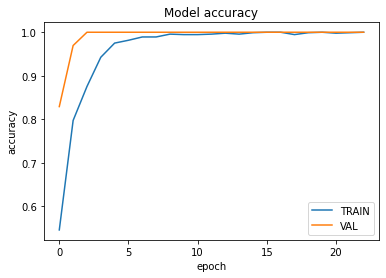

In [52]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [53]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

34/34 [==============================] - 0s 2ms/step - loss: 6.3413e-05 - accuracy: 1.0000


In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

      h-pose       1.00      1.00      1.00       338
    standing       1.00      1.00      1.00       234
      t-pose       1.00      1.00      1.00       515

    accuracy                           1.00      1087
   macro avg       1.00      1.00      1.00      1087
weighted avg       1.00      1.00      1.00      1087



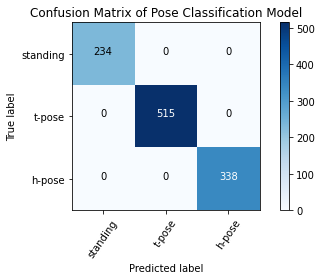

In [56]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [77]:
print(class_names[np.argmax(model.predict(X_test.iloc[:1, :]), axis=1)][0])

standing
